## Rmax sequence prediction with IBTrACS

The goal is to accurately predict Rmax time series of any given TC given a set of parameters of interest from IBTrACS (say n = 8 parameters): Vmax, R34, lon, lat, etc...

We will compare several methods: sparse regression (Lasso), analog forecasting (KNN), and Multi-Layer-Perceptron (MLP). We will also test the Chavas and Knaff 2022 model as a reference baseline. Later, we will also use Data Assimilation to answer this challenge.


In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
# import pandas as pd

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime

# Custom
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### PARAMS
PARAMS = {'time_steps_input': 4, # length of the input time series used to predict y(t)
          'save_figs':        False,
          'feature_scaling':  True,
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
}

### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'nature']

In [3]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
ds_ibt_raw

<xarray.Dataset>
Dimensions:           (storm: 2293, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] ...
    lat               (storm, date_time) float32 ...
    lon               (storm, date_time) float32 ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/147)
    numobs            (storm) float32 ...
    sid               (storm) |S13 ...
    season            (storm) float32 ...
    number            (storm) int16 ...
    basin             (storm, date_time) |S2 ...
    subbasin          (storm, date_time) |S2 ...
    ...                ...
    reunion_gust      (storm, date_time) float32 ...
    reunion_gust_per  (storm, date_time) float32 ...
    usa_seahgt        (storm, date_time) float32 ...
    usa_searad        (storm, date_time, quadrant) float32 ...
    storm_speed       (storm, date_time) float32 ...
    storm_dir         (storm, date_time) float32 ...
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [4]:
### FILTERS
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# By latitude
ds_ibt     = ds_ibt.where(np.abs(ds_ibt['lat']) <= 30)
# By removing empty Rmax time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_rmw'].notnull().sum(axis=1) > 5)
# By removing empty R34 time series
ds_ibt     = ds_ibt.where(ds_ibt['usa_r34'].notnull().sum(axis=1) > 5) 
# By agency
if os.path.basename(PATHS['ibtracs_data']) == 'IBTrACS.NA.v04r00.nc': ds_ibt     = ds_ibt.where(ds_ibt['usa_agency'] == b'hurdat_atl')

# ==> Drop NaNs
ds_ibt     = ds_ibt.dropna(dim='storm', how='all') # Much quicker to drop NaNs only at the end

In [5]:
ds_ibt

<xarray.Dataset>
Dimensions:     (storm: 236, date_time: 360, quadrant: 4)
Coordinates:
    time        (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.0000404...
    lat         (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon         (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon     (storm, date_time, quadrant) float32 -84.8 -84.8 ... nan nan
    usa_lat     (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan
    usa_wind    (storm, date_time, quadrant) float32 30.0 30.0 30.0 ... nan nan
    usa_r34     (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
    usa_rmw     (storm, date_time, quadrant) float32 50.0 50.0 50.0 ... nan nan
    numobs      (storm, date_time, quadrant) float32 48.0 48.0 48.0 ... nan nan
    sid         (storm, date_time, quadrant) object b'2001215N26275' ... nan
    basin       (storm, date_time, quadrant) object b'NA' b'NA' ... nan nan
    name        (storm, date_time, quadrant) object b'BARRY' b'BARRY' ... nan
    usa_agency  (storm, date_time, quadrant) object b'hurdat_atl' ... nan
    iso_time    (storm, date_time, quadrant) object b'2001-08-02 12:00:00' .....
    nature      (storm, date_time, quadrant) object b'TS' b'TS' ... nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [6]:
LR_variables = ['usa_lon', 'usa_lat', 'usa_r34']
ds_ibt_LR    = ds_ibt[LR_variables]
ds_ibt_LR

<xarray.Dataset>
Dimensions:  (storm: 236, date_time: 360, quadrant: 4)
Coordinates:
    time     (storm, date_time) datetime64[ns] 2001-08-02T12:00:00.000040448 ...
    lat      (storm, date_time) float32 25.7 25.98 26.2 26.32 ... nan nan nan
    lon      (storm, date_time) float32 -84.8 -84.79 -84.9 ... nan nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables:
    usa_lon  (storm, date_time, quadrant) float32 -84.8 -84.8 -84.8 ... nan nan
    usa_lat  (storm, date_time, quadrant) float32 25.7 25.7 25.7 ... nan nan nan
    usa_r34  (storm, date_time, quadrant) float32 nan nan nan ... nan nan nan
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

In [7]:
### FIRST WE AVERAGE OVER EVERY QUADRANT
PARAMS['time_steps_input']

# Pre-processing
if PARAMS['feature_scaling']:
    for param in params_of_interest:
        ds_ibt[param] = (ds_ibt[param] - ds_ibt[param].mean(dim='storm', skipna=True)) / ds_ibt[param].std(dim='storm', skipna=True)
    ds_ibt['usa_wind'] = 3 * ds_ibt['usa_wind']
    ds_ibt['usa_rmw']  = 3 * ds_ibt['usa_rmw']
    ds_ibt['usa_r34']  = 2 * ds_ibt['usa_r34']
    ds_ibt['usa_lon']  = 0.5 * ds_ibt['usa_lon']

# Separate train and test set
sep = int(0.8 * len(ds_ibt['storm'])) # 80% train, 20% test
ds_train, ds_test = ds_ibt.isel(storm=slice(None, sep)), ds_ibt.isel(storm=slice(sep, None))
print('Train set: %i storms;  '%len(ds_train['storm']), 'Test set: %i storms'%len(ds_test['storm']))

# Create Dataset
X_train, y_train = du.create_dataset(ds_train, params_of_interest, PARAMS)
X_test, y_test   = du.create_dataset(ds_test,  params_of_interest, PARAMS)
        
print('Shape of predictors matrix X_train: ', np.asarray(X_train).shape)
print('Shape of targets matrix y_train: ', np.asarray(y_train).shape)
# STRUCTURE OF X_current
# [usa_lon(t-4), usa_lon(t-3), usa_lon(t-2), ...., usa_rmw(t-3), usa_rmw(t-2), usa_rmw(t-1)] in the same way like params_of_interest
# e.g params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw']
# STRUCTURE OF y
# [usa_lon(t), usa_lat(t), usa_wind(t), usa_r34(t), usa_rmw(t)]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 

Train set: 188 storms;   Test set: 48 storms


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 53.77it/s]

Shape of predictors matrix X_train:  (2413, 20)
Shape of targets matrix y_train:  (2413, 5)


In [8]:
# for k in range(5):
#     plt.plot(X[k][-4:])

In [9]:
### FIT LINEAR REGRESSION
lrg = linear_model.LinearRegression()
lrg.fit(X_train, y_train)
print('==> LINEAR \nR2: ',     lrg.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(lrg.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(lrg.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(lrg.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

### FIT LASSO
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print('==> LASSO \nR2: ',      clf.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(clf.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(clf.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(clf.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

### FIT K-NEAREST NEIGHBORS
knn   = neighbors.KNeighborsRegressor(n_neighbors=10, weights='distance')
knn.fit(X_train, y_train)
print('==> KNN \nR2: ',        knn.score(X_test, y_test))
print('RMSE Vmax (kts): ', du.rmse(knn.predict(X_test)[:, 2], np.asarray(y_test)[:, 2]))
print('RMSE R34  (n.m): ', du.rmse(knn.predict(X_test)[:, 3], np.asarray(y_test)[:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(knn.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))

# Optimize nb of analogs
# R2s = []
# for n in tqdm(range(50)):
#     knn   = neighbors.KNeighborsRegressor(n_neighbors=n + 1, weights='distance')
#     knn.fit(X_train, y_train)
#     R2s.append(knn.score(X_test, y_test))
#     # R2s.append(du.rmse(knn.predict(X_test)[:, 4], np.asarray(y_test)[:, 4]))
# plt.plot(R2s);plt.grid()

### Select model
model = lrg

print('==> BASE')
print('RMSE Vmax (kts): ', du.rmse(np.asarray(y_test)[:-1, 2], np.asarray(y_test)[1:, 2]))
print('RMSE R34  (n.m): ', du.rmse(np.asarray(y_test)[:-1, 3], np.asarray(y_test)[1:, 3]))
print('RMSE Vmax (n.m): ', du.rmse(np.asarray(y_test)[:-1, 4], np.asarray(y_test)[1:, 4]))

==> LINEAR 
R2:  0.8875383667673568
RMSE Vmax (kts):  0.8334196691246136
RMSE R34  (n.m):  0.5584501048540673
RMSE Vmax (n.m):  1.3823207924626597
==> LASSO 
R2:  0.8437879832211037
RMSE Vmax (kts):  0.8669654533501496
RMSE R34  (n.m):  0.5608941853759817
RMSE Vmax (n.m):  1.384067395151604
==> KNN 
R2:  0.6956782773708803
RMSE Vmax (kts):  1.0803395372232
RMSE R34  (n.m):  0.8265967347044721
RMSE Vmax (n.m):  1.609624375844963
==> BASE
RMSE Vmax (kts):  1.2734030968158756
RMSE R34  (n.m):  0.819343395209392
RMSE Vmax (n.m):  1.770204662293342


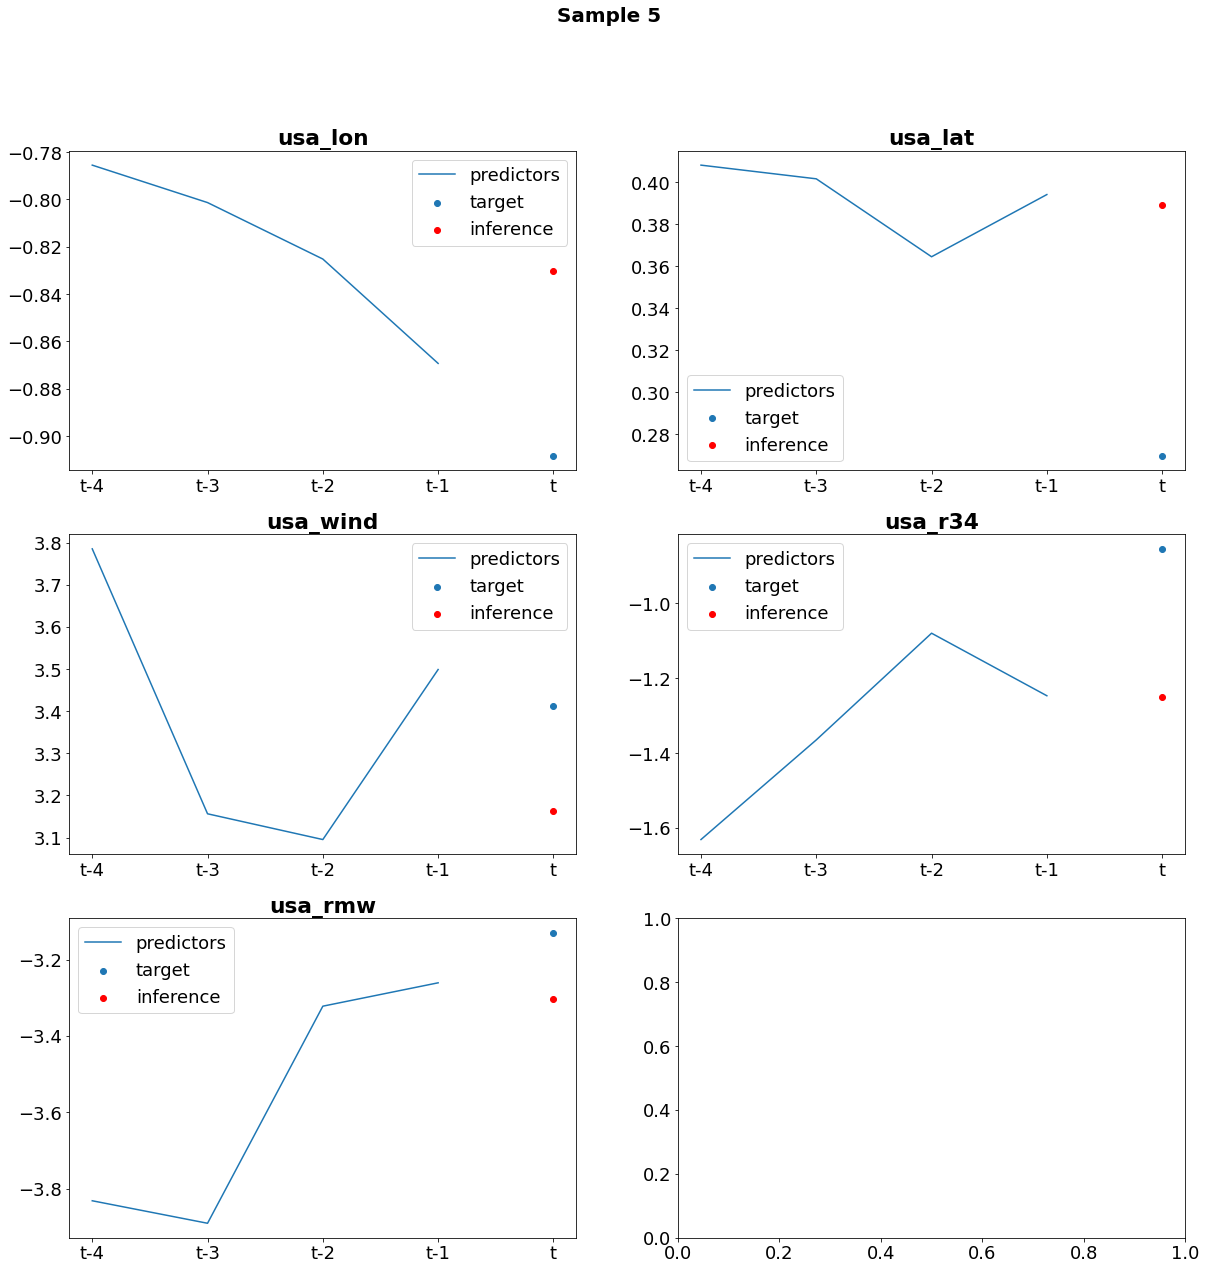

In [10]:
### PLOT ONE SAMPLE INFERENCE PHASE
# k          = 0 # index of sample to test

for k in range(5, 6):
    # Figure attributes and legend
    (fig, axs) = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
    xaxis      = np.arange(PARAMS['time_steps_input'] + 1)
    a          = [str(e) for e in (xaxis - PARAMS['time_steps_input'])]
    b          = ['t' for e in range(PARAMS['time_steps_input'] + 1)]
    ticks      = [b[i] + a[i] for i in range(len(b) - 1)] + b[-1:]
    fig.suptitle('Sample %i'%k, fontsize=20, weight='bold')

    for i, ax in enumerate(axs.flatten()[:-1]):
        # Predictors
        j = i * PARAMS['time_steps_input']
        ax.plot(np.asarray(X_test)[k, j:j + PARAMS['time_steps_input']], label='predictors') # Storm k, variable of inputs j to j + time_steps_input (e.g latitude)

        # Target
        ax.scatter(PARAMS['time_steps_input'], np.asarray(y_test)[k, i], label='target')     # Storm k, variable i (e.g latitude)

        # Inference
        ax.scatter(PARAMS['time_steps_input'], model.predict(X_test[k:k + 1])[0, i], label='inference', c='r') # Storm k, variable i (e.g latitude)

        # Figure
        ax.set_title(params_of_interest[i], weight='bold')
        ax.set_xticks(xaxis, ticks)
        ax.legend()

Storm name:  b'ETA'
Storm ID:  b'2020306N15288'
Storm name:  b'THETA'
Storm ID:  b'2020314N28313'
Storm name:  b'IOTA'
Storm ID:  b'2020318N16289'


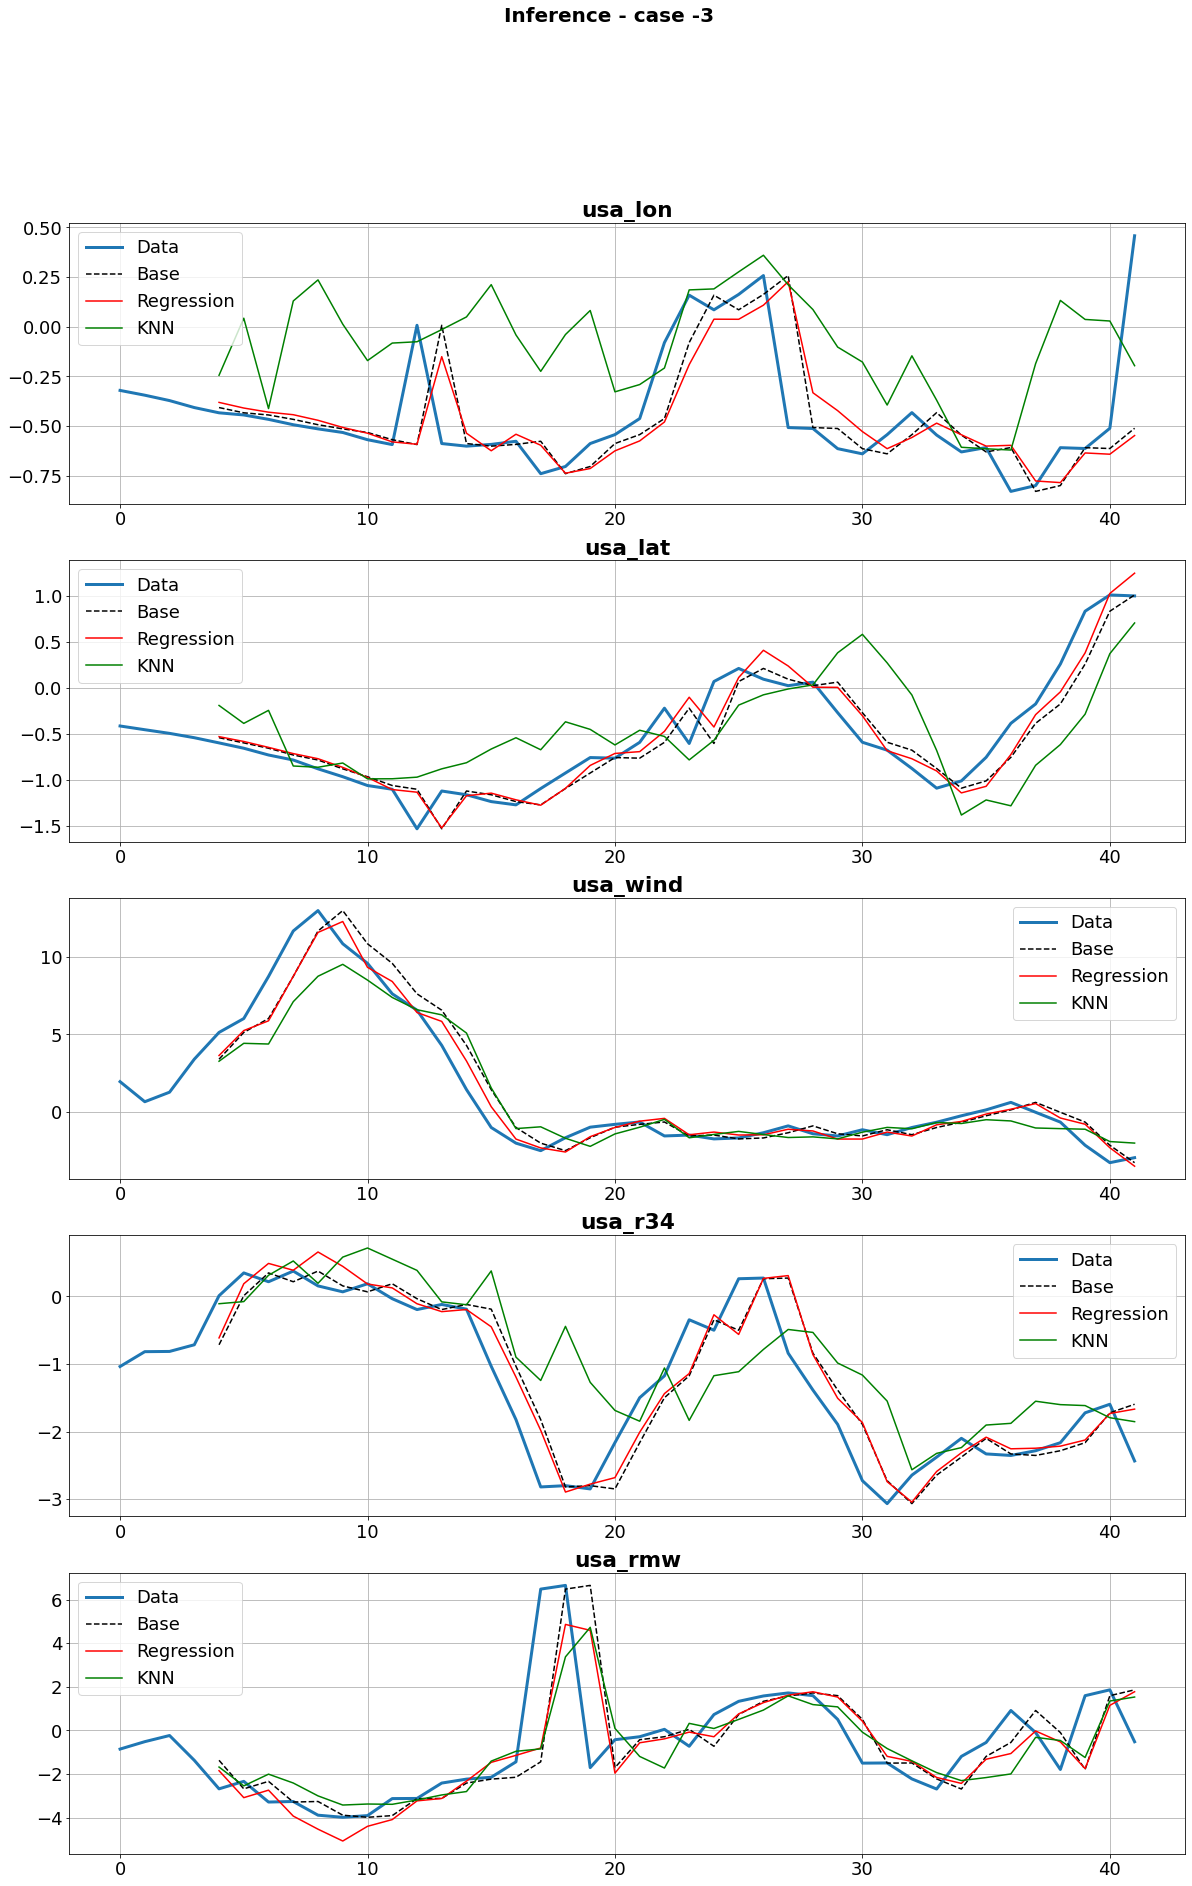

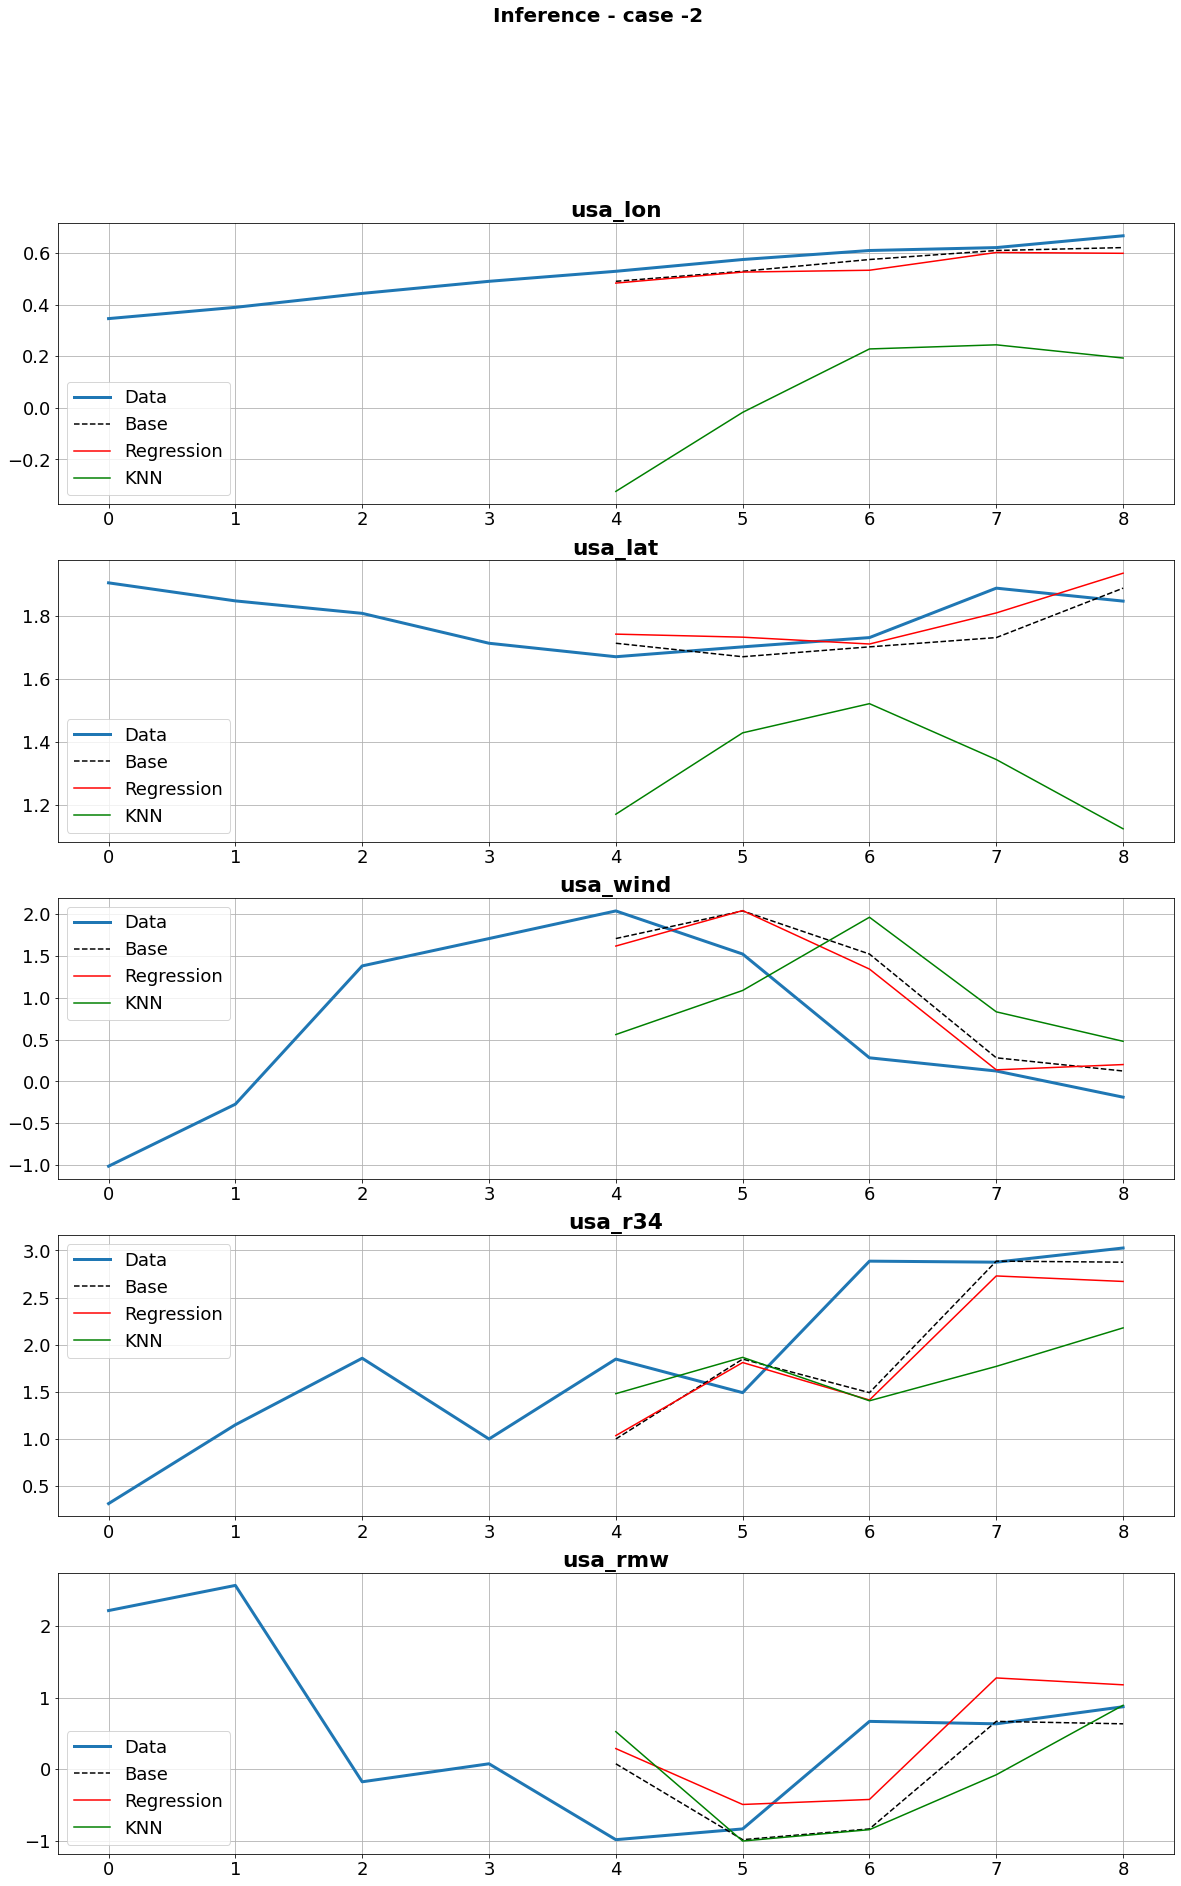

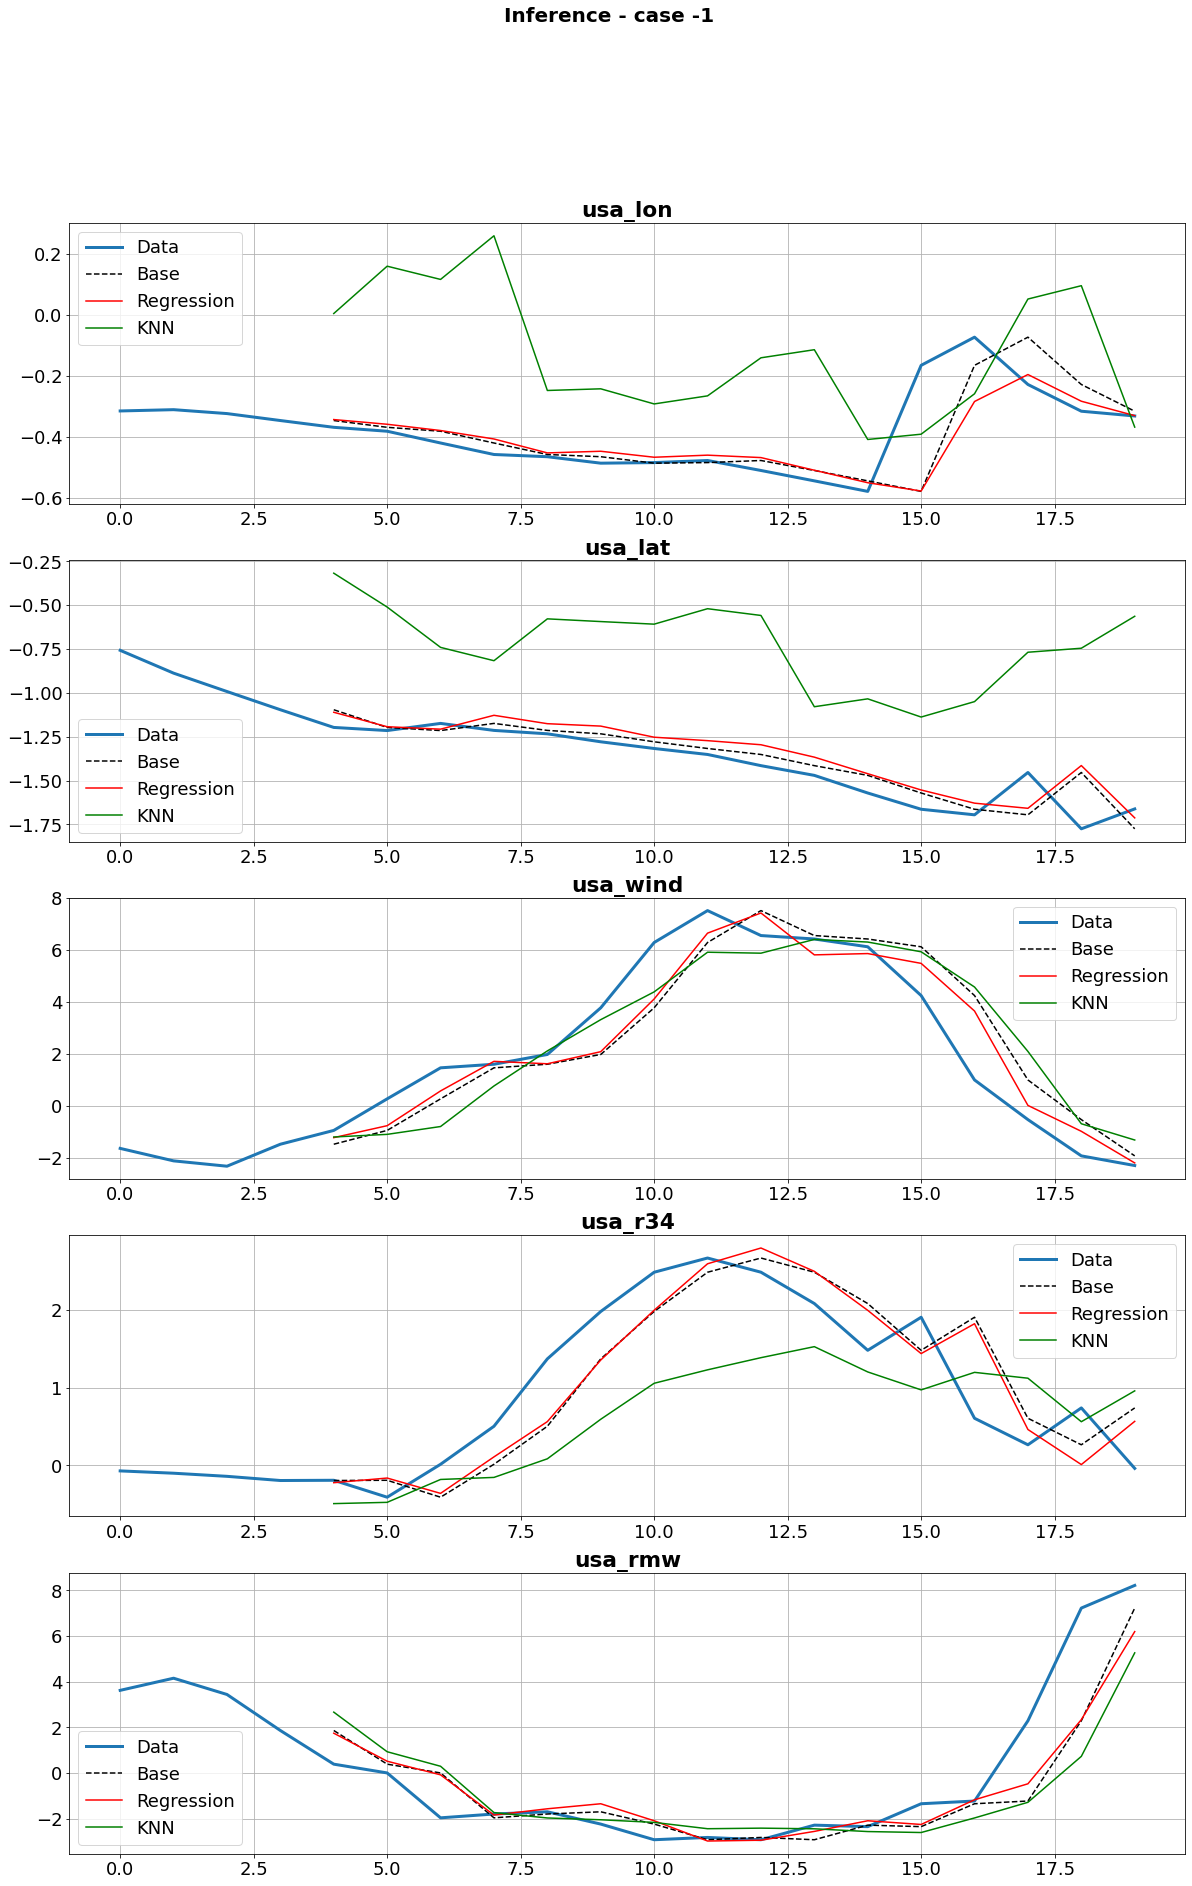

In [11]:
### INFERENCE ON ILLUSTRATIVE CASES
# Select storm
s  = 0 # 75, 80, 120, 130

# -18 to -16 for .ALL dataset
for s in range(-3, 0):
    # s  = -1 
    ds = ds_test.isel(storm=s)
    
    print('Storm name: ', str(ds_test.isel(storm=s)['name'][0][0].values))
    print('Storm ID: ', str(ds_test.isel(storm=s)['sid'][0][0].values))
    # Get only valid stime steps
    ds = ds[params_of_interest].mean(dim='quadrant', skipna=True)
    ds = ds.dropna(dim='date_time', subset=params_of_interest)

    # Prepare inference input
    X_inference = [] 
    for i in range(len(ds.date_time) - PARAMS['time_steps_input']):
        ds_sub = ds.isel(date_time=slice(i, i + PARAMS['time_steps_input']))
        X_current = []
        for param in params_of_interest:
            for e in ds_sub[param].values:
                X_current.append(e) # inputs
        X_inference.append(X_current)


    # Plot
    (fig, axs) = plt.subplots(nrows=5, ncols=1, figsize=(20, 30))
    xaxis      = np.arange(len(ds.date_time))
    fig.suptitle('Inference - case %i'%s, fontsize=20, weight='bold')

    for i, ax in enumerate(axs.flatten()):
        # Data
        ax.plot(xaxis, ds[params_of_interest[i]], label='Data', linewidth=3)

        # Base
        ax.plot((xaxis + 1)[PARAMS['time_steps_input'] - 1:-1], ds[params_of_interest[i]][PARAMS['time_steps_input'] - 1:-1], label='Base', color='k', linestyle='--')

        # Inference
        ax.plot(xaxis[PARAMS['time_steps_input']:], lrg.predict(X_inference)[:, i], label='Regression', c='r')
        ax.plot(xaxis[PARAMS['time_steps_input']:], knn.predict(X_inference)[:, i], label='KNN',        c='g')

        # Figure
        ax.set_title(params_of_interest[i], weight='bold')
        # ax.set_xticks(xaxis)
        ax.grid()
        ax.legend()

In [12]:
### Compute RMSEs
# Analog forecasting (k-means then average)